# 3. Model Evaluation and Export

**Project:** IoT Network Attack Detection using Federated Learning  
**Author:** Nguyen Duc Thang

---

## 📋 Objectives

1. Load trained global model
2. Generate predictions on test set
3. Calculate comprehensive metrics:
   - Overall accuracy
   - Per-class Precision, Recall, F1-Score
   - Confusion Matrix
4. Create visualizations for thesis report
5. Export all metrics and artifacts

---

## 🎯 Expected Outputs

- `../Output/metrics/confusion_matrix.png`
- `../Output/metrics/accuracy_plot.png`
- `../Output/metrics/f1_scores_per_class.png`
- `../Output/metrics/metrics_report.json`

## 1. Setup and Imports

In [1]:
# Standard libraries
import os
import sys
import numpy as np
import pandas as pd
import json
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, classification_report, 
    accuracy_score, precision_recall_fscore_support
)

# TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras

# Import our utility modules
from utils import data_utils, model_utils

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300  # High resolution for thesis

print("✅ All imports successful!")

2025-12-28 14:31:04.441005: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


✅ All imports successful!


## 2. Load Trained Model and Test Data

In [2]:
# Load trained model
model_path = '../Output/models/global_model.h5'
print(f"📂 Loading trained model from: {model_path}")
model = model_utils.load_model(model_path)

# Load test data
data_dir = '../Output/data'
test_data = data_utils.load_client_data(data_dir, 'test')
X_test = test_data['X']
y_test = test_data['y']

print(f"\n✅ Data loaded:")
print(f"   Test samples: {len(X_test):,}")
print(f"   Features: {X_test.shape[1]}")
print(f"   Classes: {len(np.unique(y_test))}")

📂 Loading trained model from: ../Output/models/global_model.h5

📂 Loading model from: ../Output/models/global_model.h5
   ✓ Model loaded successfully

✅ Data loaded:
   Test samples: 523,670
   Features: 46
   Classes: 34


## 3. Load Label Mapping

In [3]:
# Load label mapping
labels_path = '../Output/models/labels.json'
with open(labels_path, 'r') as f:
    label_mapping = json.load(f)

# Convert keys to integers
label_mapping = {int(k): v for k, v in label_mapping.items()}

print(f"📋 Label mapping loaded ({len(label_mapping)} classes):")
for i in range(min(10, len(label_mapping))):
    print(f"   {i}: {label_mapping[i]}")
if len(label_mapping) > 10:
    print(f"   ... and {len(label_mapping) - 10} more")

📋 Label mapping loaded (34 classes):
   0: Backdoor_Malware
   1: BenignTraffic
   2: BrowserHijacking
   3: CommandInjection
   4: DDoS-ACK_Fragmentation
   5: DDoS-HTTP_Flood
   6: DDoS-ICMP_Flood
   7: DDoS-ICMP_Fragmentation
   8: DDoS-PSHACK_Flood
   9: DDoS-RSTFINFlood
   ... and 24 more


## 4. Generate Predictions

In [4]:
# Generate predictions
print("🔮 Generating predictions on test set...")
y_pred_proba = model.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)

print(f"\n✅ Predictions generated!")
print(f"   Prediction shape: {y_pred.shape}")
print(f"   Unique predicted classes: {len(np.unique(y_pred))}")

🔮 Generating predictions on test set...
16365/16365 [==============================] - 29s 2ms/step

✅ Predictions generated!
   Prediction shape: (523670,)
   Unique predicted classes: 13


## 5. Calculate Overall Metrics

In [5]:
# Calculate overall accuracy
overall_accuracy = accuracy_score(y_test, y_pred)

# Calculate per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(
    y_test, y_pred, average=None, zero_division=0
)

# Calculate macro and weighted averages
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    y_test, y_pred, average='macro', zero_division=0
)

precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
    y_test, y_pred, average='weighted', zero_division=0
)

print("="*80)
print("OVERALL METRICS")
print("="*80)
print(f"\n📊 Overall Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")
print(f"\n📈 Macro Averages (unweighted):")
print(f"   Precision: {precision_macro:.4f}")
print(f"   Recall: {recall_macro:.4f}")
print(f"   F1-Score: {f1_macro:.4f}")
print(f"\n📈 Weighted Averages (by support):")
print(f"   Precision: {precision_weighted:.4f}")
print(f"   Recall: {recall_weighted:.4f}")
print(f"   F1-Score: {f1_weighted:.4f}")
print("="*80)

# Check if target met
if overall_accuracy >= 0.95:
    print(f"\n✅ SUCCESS: Target accuracy (>95%) achieved!")
else:
    print(f"\n⚠️  Target accuracy (>95%) not achieved.")
    print(f"   Gap: {(0.95 - overall_accuracy)*100:.2f}%")

OVERALL METRICS

📊 Overall Accuracy: 0.4075 (40.75%)

📈 Macro Averages (unweighted):
   Precision: 0.1522
   Recall: 0.1848
   F1-Score: 0.1209

📈 Weighted Averages (by support):
   Precision: 0.3082
   Recall: 0.4075
   F1-Score: 0.2981

⚠️  Target accuracy (>95%) not achieved.
   Gap: 54.25%


## 6. Per-Class Metrics

In [6]:
# Create per-class metrics DataFrame
metrics_df = pd.DataFrame({
    'Class': [label_mapping[i] for i in range(len(precision))],
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

# Sort by F1-Score
metrics_df = metrics_df.sort_values('F1-Score', ascending=False)

print("\n📊 Per-Class Metrics (sorted by F1-Score):")
display(metrics_df)

# Check classes below threshold
threshold = 0.85
low_f1_classes = metrics_df[metrics_df['F1-Score'] < threshold]

if len(low_f1_classes) > 0:
    print(f"\n⚠️  Classes with F1-Score < {threshold}:")
    display(low_f1_classes)
else:
    print(f"\n✅ All classes have F1-Score >= {threshold}!")


📊 Per-Class Metrics (sorted by F1-Score):


,Class,Precision,Recall,F1-Score,Support
8,DDoS-PSHACK_Flood,0.999735,0.982575,0.991080,46025
9,DDoS-RSTFINFlood,0.624207,0.998897,0.768304,45335
6,DDoS-ICMP_Flood,0.451992,0.998873,0.622364,80759
5,DDoS-HTTP_Flood,0.304147,0.825000,0.444444,320
12,DDoS-SynonymousIP_Flood,0.962230,0.226025,0.366062,40239
4,DDoS-ACK_Fragmentation,1.000000,0.163438,0.280956,3200
20,DoS-TCP_Flood,0.161287,0.996556,0.277640,29911
16,DNS_Spoofing,0.091711,0.973866,0.167636,2028
11,DDoS-SlowLoris,0.438596,0.095785,0.157233,261
10,DDoS-SYN_Flood,0.063624,0.010404,0.017884,45559



⚠️  Classes with F1-Score < 0.85:


,Class,Precision,Recall,F1-Score,Support
9,DDoS-RSTFINFlood,0.624207,0.998897,0.768304,45335
6,DDoS-ICMP_Flood,0.451992,0.998873,0.622364,80759
5,DDoS-HTTP_Flood,0.304147,0.825000,0.444444,320
12,DDoS-SynonymousIP_Flood,0.962230,0.226025,0.366062,40239
4,DDoS-ACK_Fragmentation,1.000000,0.163438,0.280956,3200
20,DoS-TCP_Flood,0.161287,0.996556,0.277640,29911
16,DNS_Spoofing,0.091711,0.973866,0.167636,2028
11,DDoS-SlowLoris,0.438596,0.095785,0.157233,261
10,DDoS-SYN_Flood,0.063624,0.010404,0.017884,45559
7,DDoS-ICMP_Fragmentation,0.058824,0.006717,0.012057,5062


## 7. Confusion Matrix

In [7]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

print(f"📊 Confusion Matrix shape: {cm.shape}")
print(f"   Diagonal sum (correct predictions): {np.trace(cm):,}")
print(f"   Off-diagonal sum (misclassifications): {cm.sum() - np.trace(cm):,}")

📊 Confusion Matrix shape: (34, 34)
   Diagonal sum (correct predictions): 213,417
   Off-diagonal sum (misclassifications): 310,253


### 7.1 Visualize Confusion Matrix

💾 Confusion matrix saved to: ../Output/metrics/confusion_matrix.png


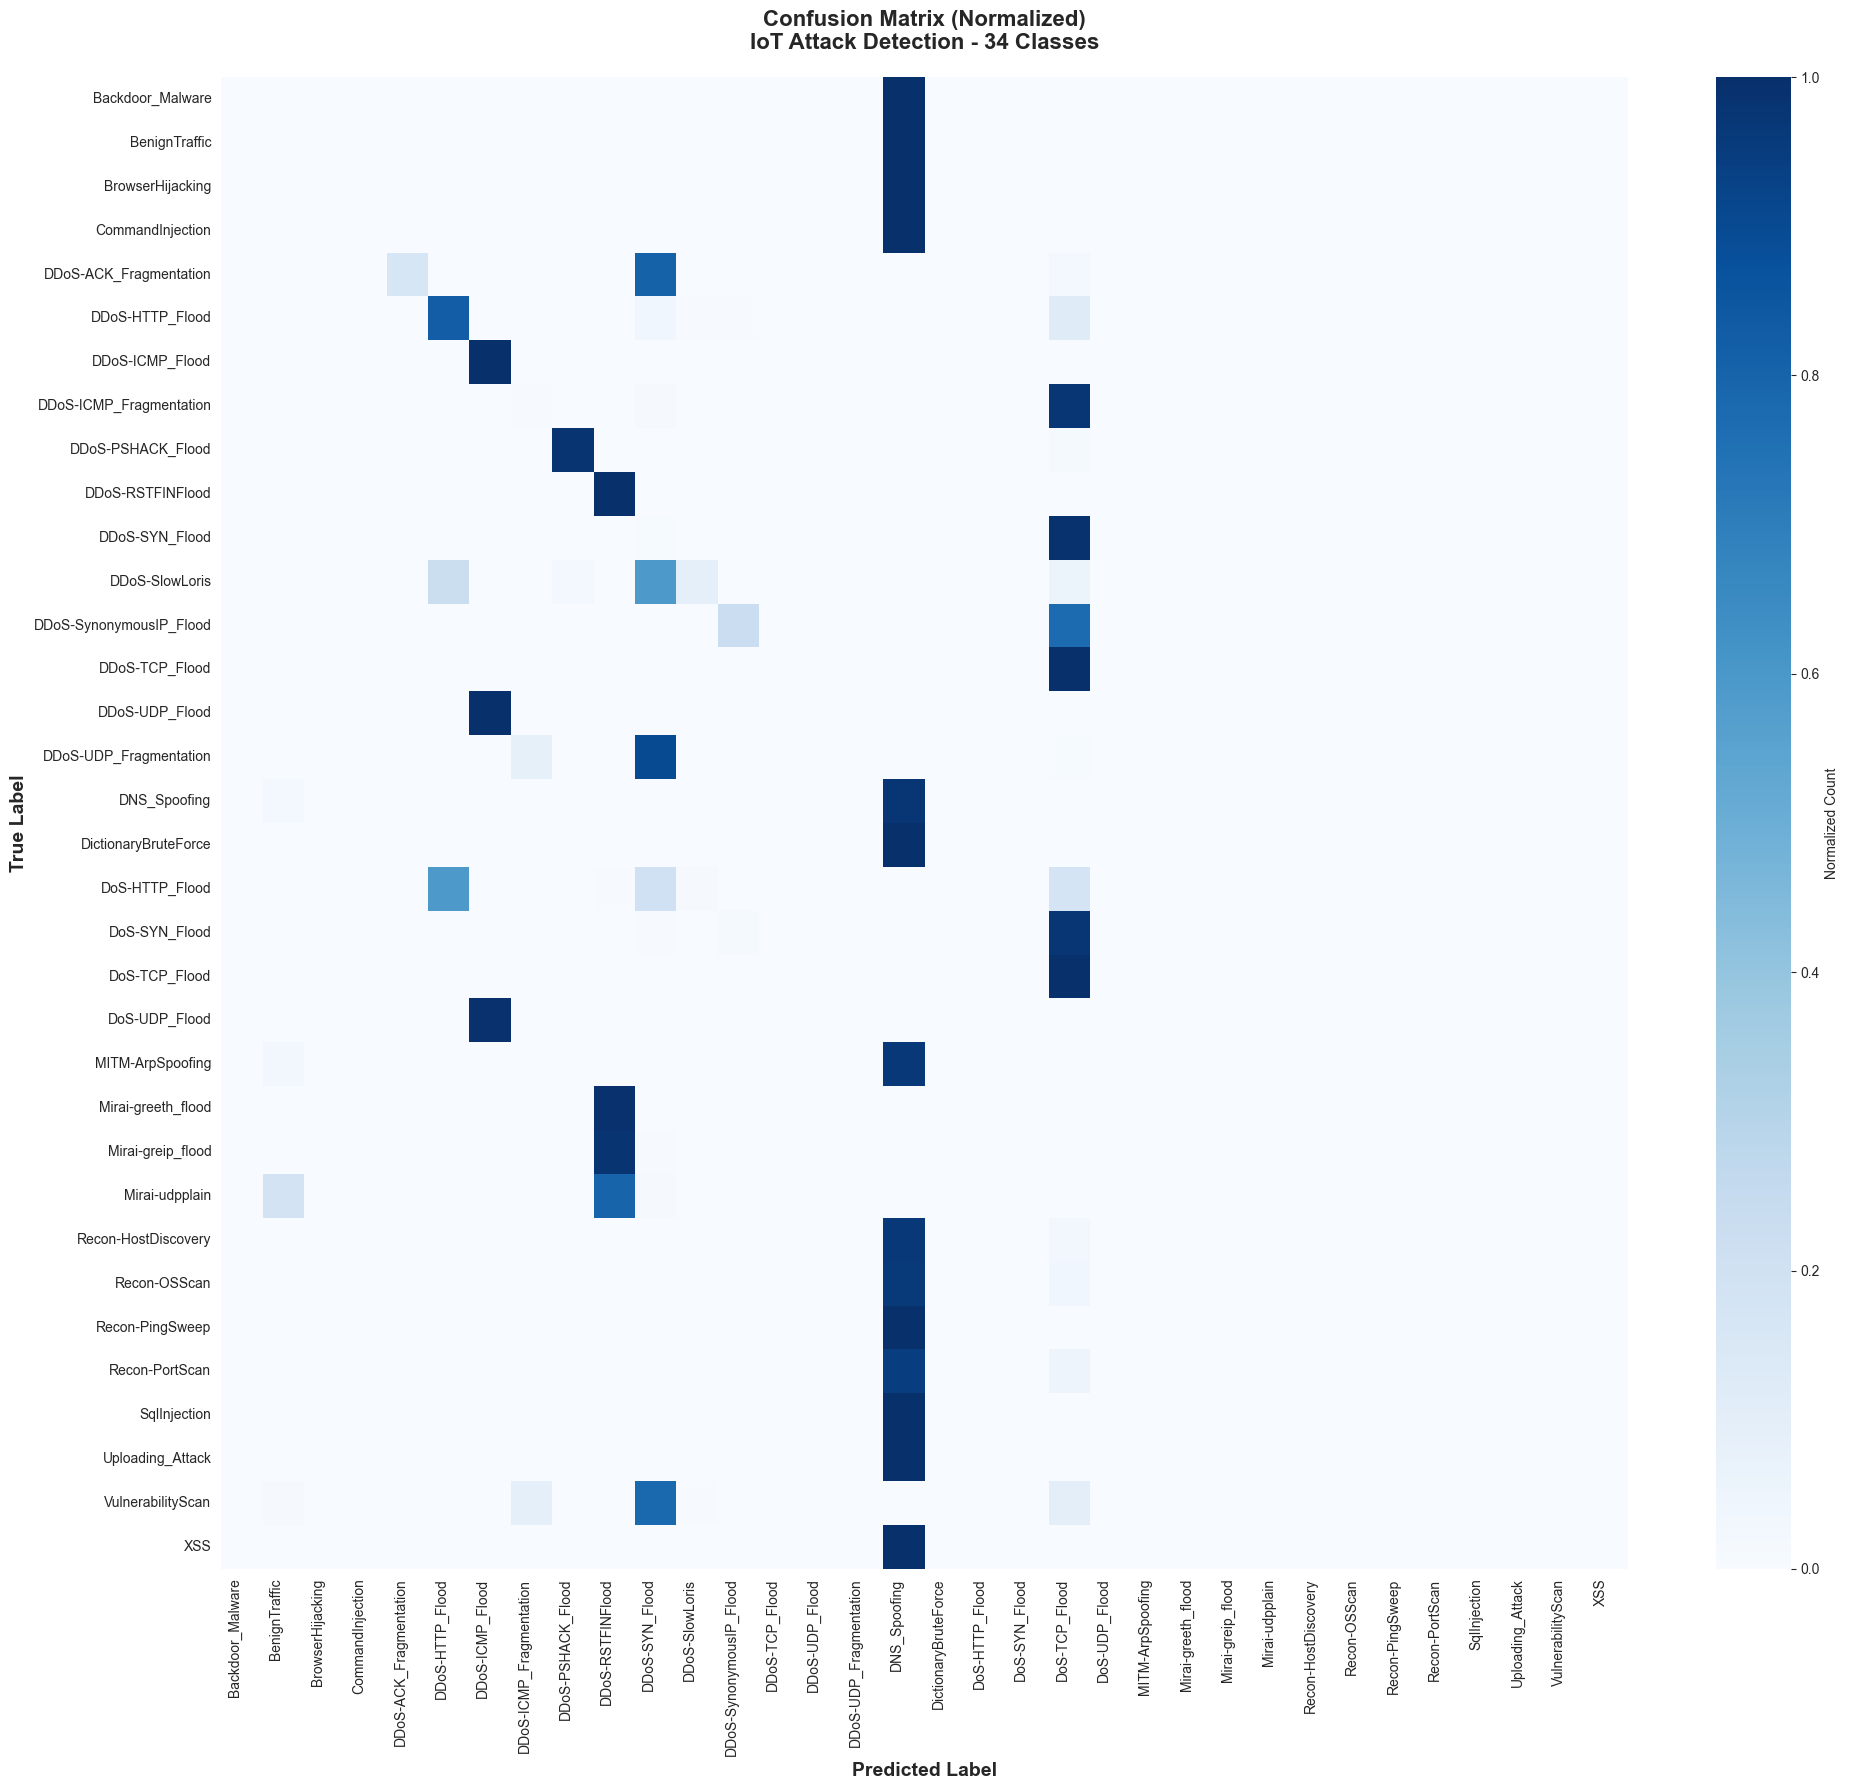

In [8]:
# Create confusion matrix heatmap
plt.figure(figsize=(20, 18))

# Normalize confusion matrix for better visualization
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create heatmap
sns.heatmap(cm_normalized, annot=False, fmt='.2f', cmap='Blues', 
            xticklabels=[label_mapping[i] for i in range(len(cm))],
            yticklabels=[label_mapping[i] for i in range(len(cm))],
            cbar_kws={'label': 'Normalized Count'})

plt.title('Confusion Matrix (Normalized)\nIoT Attack Detection - 34 Classes', 
         fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=14, fontweight='bold')
plt.xticks(rotation=90, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Save figure
output_path = '../Output/metrics/confusion_matrix.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"💾 Confusion matrix saved to: {output_path}")

plt.show()

## 8. Training History Visualization

💾 Training curves saved to: ../Output/metrics/accuracy_plot.png


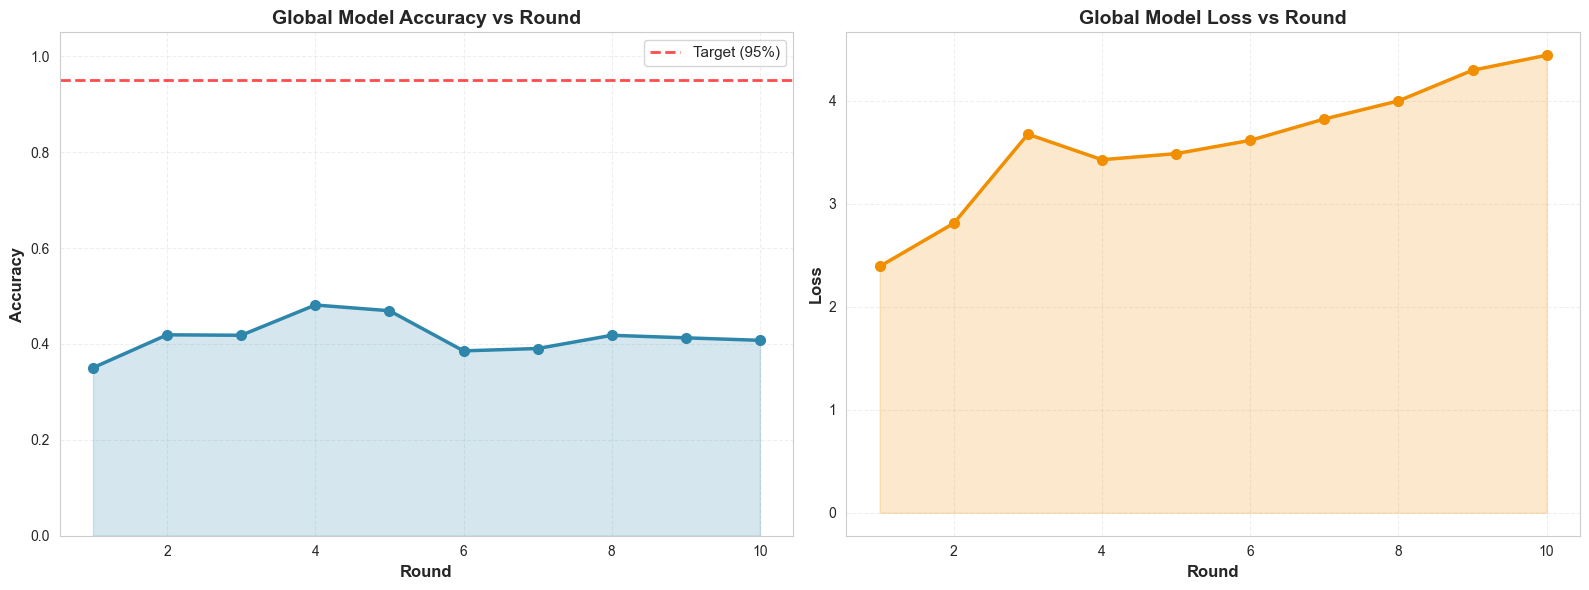

In [9]:
# Load training history
history_path = '../Output/metrics/training_history.json'
with open(history_path, 'r') as f:
    training_history = json.load(f)

# Extract data
rounds = training_history['history']['round']
accuracy = training_history['history']['accuracy']
loss = training_history['history']['loss']

# Create plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot accuracy
axes[0].plot(rounds, accuracy, marker='o', linewidth=2.5, markersize=7, color='#2E86AB')
axes[0].axhline(y=0.95, color='red', linestyle='--', linewidth=2, label='Target (95%)', alpha=0.7)
axes[0].fill_between(rounds, 0, accuracy, alpha=0.2, color='#2E86AB')
axes[0].set_title('Global Model Accuracy vs Round', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Round', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[0].set_ylim([0, 1.05])
axes[0].grid(True, alpha=0.3, linestyle='--')
axes[0].legend(fontsize=11)

# Plot loss
axes[1].plot(rounds, loss, marker='o', linewidth=2.5, markersize=7, color='#F18F01')
axes[1].fill_between(rounds, 0, loss, alpha=0.2, color='#F18F01')
axes[1].set_title('Global Model Loss vs Round', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Round', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()

# Save figure
output_path = '../Output/metrics/accuracy_plot.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"💾 Training curves saved to: {output_path}")

plt.show()

## 9. Per-Class F1-Score Visualization

💾 F1-Score chart saved to: ../Output/metrics/f1_scores_per_class.png


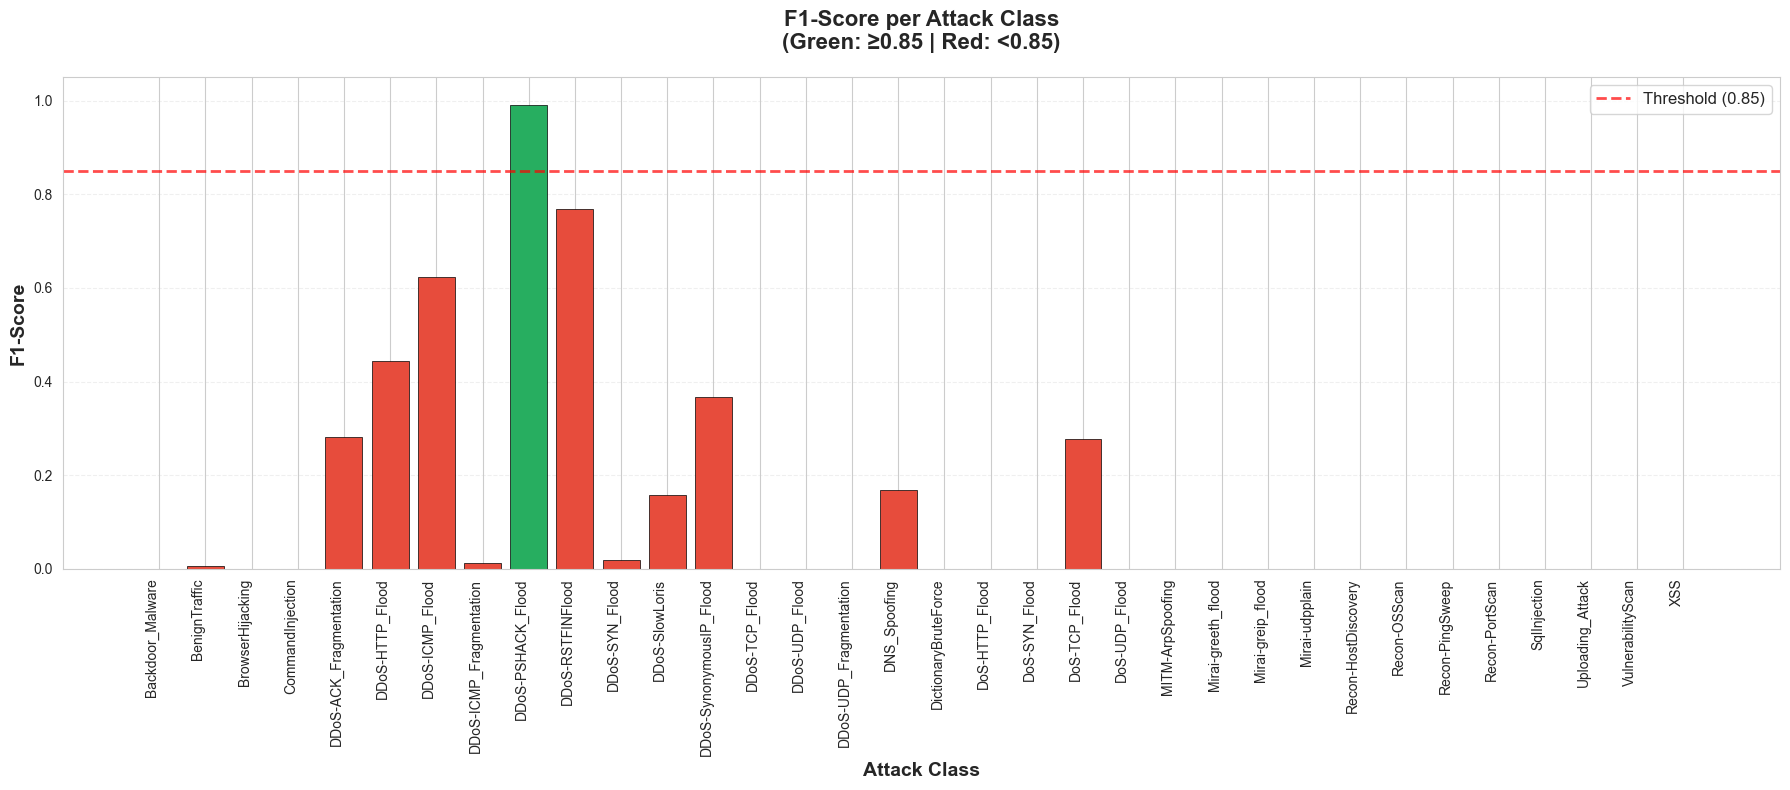


📊 F1-Score Summary:
   Classes with F1 ≥ 0.85: 1/34 (2.9%)
   Classes with F1 < 0.85: 33/34 (97.1%)


In [10]:
# Create F1-Score bar chart
plt.figure(figsize=(18, 8))

# Prepare data
class_names = [label_mapping[i] for i in range(len(f1))]
colors = ['#27AE60' if score >= 0.85 else '#E74C3C' for score in f1]

# Create bar chart
bars = plt.bar(range(len(f1)), f1, color=colors, edgecolor='black', linewidth=0.5)

# Add threshold line
plt.axhline(y=0.85, color='red', linestyle='--', linewidth=2, 
           label='Threshold (0.85)', alpha=0.7)

# Customize plot
plt.title('F1-Score per Attack Class\n(Green: ≥0.85 | Red: <0.85)', 
         fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Attack Class', fontsize=14, fontweight='bold')
plt.ylabel('F1-Score', fontsize=14, fontweight='bold')
plt.xticks(range(len(f1)), class_names, rotation=90, ha='right')
plt.ylim([0, 1.05])
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.legend(fontsize=12)
plt.tight_layout()

# Save figure
output_path = '../Output/metrics/f1_scores_per_class.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"💾 F1-Score chart saved to: {output_path}")

plt.show()

# Print summary
num_above_threshold = np.sum(f1 >= 0.85)
num_below_threshold = np.sum(f1 < 0.85)

print(f"\n📊 F1-Score Summary:")
print(f"   Classes with F1 ≥ 0.85: {num_above_threshold}/{len(f1)} ({num_above_threshold/len(f1)*100:.1f}%)")
print(f"   Classes with F1 < 0.85: {num_below_threshold}/{len(f1)} ({num_below_threshold/len(f1)*100:.1f}%)")

## 10. Export Comprehensive Metrics Report

In [11]:
# Prepare comprehensive metrics report
metrics_report = {
    'overall_metrics': {
        'accuracy': float(overall_accuracy),
        'precision_macro': float(precision_macro),
        'recall_macro': float(recall_macro),
        'f1_macro': float(f1_macro),
        'precision_weighted': float(precision_weighted),
        'recall_weighted': float(recall_weighted),
        'f1_weighted': float(f1_weighted)
    },
    'per_class_metrics': {},
    'summary': {
        'total_test_samples': int(len(y_test)),
        'num_classes': int(len(label_mapping)),
        'classes_above_f1_threshold': int(num_above_threshold),
        'classes_below_f1_threshold': int(num_below_threshold),
        'target_accuracy_met': bool(overall_accuracy >= 0.95),
        'all_classes_above_threshold': bool(num_below_threshold == 0)
    },
    'confusion_matrix': cm.tolist()
}

# Add per-class metrics
for i in range(len(precision)):
    class_name = label_mapping[i]
    metrics_report['per_class_metrics'][class_name] = {
        'class_id': int(i),
        'precision': float(precision[i]),
        'recall': float(recall[i]),
        'f1_score': float(f1[i]),
        'support': int(support[i])
    }

# Save to JSON
report_path = '../Output/metrics/metrics_report.json'
with open(report_path, 'w') as f:
    json.dump(metrics_report, f, indent=2)

print(f"💾 Comprehensive metrics report saved to: {report_path}")
print(f"\n✅ Report includes:")
print(f"   - Overall metrics (accuracy, precision, recall, F1)")
print(f"   - Per-class metrics for all {len(label_mapping)} classes")
print(f"   - Confusion matrix")
print(f"   - Summary statistics")

💾 Comprehensive metrics report saved to: ../Output/metrics/metrics_report.json

✅ Report includes:
   - Overall metrics (accuracy, precision, recall, F1)
   - Per-class metrics for all 34 classes
   - Confusion matrix
   - Summary statistics


## 11. Generate Classification Report

In [12]:
# Generate sklearn classification report
target_names = [label_mapping[i] for i in range(len(label_mapping))]
report = classification_report(y_test, y_pred, target_names=target_names, zero_division=0)

print("="*80)
print("CLASSIFICATION REPORT")
print("="*80)
print(report)

# Save to text file
report_txt_path = '../Output/metrics/classification_report.txt'
with open(report_txt_path, 'w') as f:
    f.write("CLASSIFICATION REPORT\n")
    f.write("="*80 + "\n")
    f.write(report)

print(f"\n💾 Classification report saved to: {report_txt_path}")

CLASSIFICATION REPORT
                         precision    recall  f1-score   support

       Backdoor_Malware       0.00      0.00      0.00        38
          BenignTraffic       0.02      0.00      0.01     12370
       BrowserHijacking       0.00      0.00      0.00        64
       CommandInjection       0.00      0.00      0.00        56
 DDoS-ACK_Fragmentation       1.00      0.16      0.28      3200
        DDoS-HTTP_Flood       0.30      0.82      0.44       320
        DDoS-ICMP_Flood       0.45      1.00      0.62     80759
DDoS-ICMP_Fragmentation       0.06      0.01      0.01      5062
      DDoS-PSHACK_Flood       1.00      0.98      0.99     46025
       DDoS-RSTFINFlood       0.62      1.00      0.77     45335
         DDoS-SYN_Flood       0.06      0.01      0.02     45559
         DDoS-SlowLoris       0.44      0.10      0.16       261
DDoS-SynonymousIP_Flood       0.96      0.23      0.37     40239
         DDoS-TCP_Flood       0.00      0.00      0.00     50628
  

## 12. Final Summary

In [13]:
print("="*80)
print("MODEL EVALUATION SUMMARY")
print("="*80)

print(f"\n📊 Performance Metrics:")
print(f"   Overall Accuracy: {overall_accuracy*100:.2f}%")
print(f"   Macro F1-Score: {f1_macro:.4f}")
print(f"   Weighted F1-Score: {f1_weighted:.4f}")

print(f"\n🎯 Target Achievement:")
if overall_accuracy >= 0.95:
    print(f"   ✅ Accuracy target (>95%): ACHIEVED")
else:
    print(f"   ❌ Accuracy target (>95%): NOT ACHIEVED (Gap: {(0.95-overall_accuracy)*100:.2f}%)")

if num_below_threshold == 0:
    print(f"   ✅ F1-Score target (>0.85 for all classes): ACHIEVED")
else:
    print(f"   ⚠️  F1-Score target: {num_below_threshold} classes below 0.85")

print(f"\n📁 Generated Files:")
output_files = [
    '../Output/metrics/confusion_matrix.png',
    '../Output/metrics/accuracy_plot.png',
    '../Output/metrics/f1_scores_per_class.png',
    '../Output/metrics/metrics_report.json',
    '../Output/metrics/classification_report.txt'
]

for file_path in output_files:
    if os.path.exists(file_path):
        file_size = os.path.getsize(file_path) / 1024  # KB
        print(f"   ✓ {os.path.basename(file_path)} ({file_size:.2f} KB)")

print(f"\n💾 All Deliverables for Web App:")
deliverables = [
    '../Output/models/global_model.h5',
    '../Output/models/scaler.pkl',
    '../Output/models/label_encoder.pkl',
    '../Output/models/labels.json'
]

for file_path in deliverables:
    if os.path.exists(file_path):
        file_size = os.path.getsize(file_path) / 1024  # KB
        if file_path.endswith('.h5'):
            file_size = file_size / 1024  # MB for model
            print(f"   ✓ {os.path.basename(file_path)} ({file_size:.2f} MB)")
        else:
            print(f"   ✓ {os.path.basename(file_path)} ({file_size:.2f} KB)")

print(f"\n✅ MODEL EVALUATION COMPLETE!")
print(f"\n📝 Next steps:")
print(f"   1. Review all visualizations and metrics")
print(f"   2. Include plots in thesis report")
print(f"   3. Use deliverables for Web App integration")
print("="*80)

MODEL EVALUATION SUMMARY

📊 Performance Metrics:
   Overall Accuracy: 40.75%
   Macro F1-Score: 0.1209
   Weighted F1-Score: 0.2981

🎯 Target Achievement:
   ❌ Accuracy target (>95%): NOT ACHIEVED (Gap: 54.25%)
   ⚠️  F1-Score target: 33 classes below 0.85

📁 Generated Files:
   ✓ confusion_matrix.png (762.74 KB)
   ✓ accuracy_plot.png (196.13 KB)
   ✓ f1_scores_per_class.png (418.00 KB)
   ✓ metrics_report.json (16.59 KB)
   ✓ classification_report.txt (2.51 KB)

💾 All Deliverables for Web App:
   ✓ global_model.h5 (0.09 MB)
   ✓ scaler.pkl (2.83 KB)
   ✓ label_encoder.pkl (0.85 KB)
   ✓ labels.json (0.91 KB)

✅ MODEL EVALUATION COMPLETE!

📝 Next steps:
   1. Review all visualizations and metrics
   2. Include plots in thesis report
   3. Use deliverables for Web App integration
